# Working with parquet files

## Objective

+ In this assignment, we will use the data downloaded with the module `data_manager` to create features.

(11 pts total)

## Prerequisites

+ This notebook assumes that price data is available to you in the environment variable `PRICE_DATA`. If you have not done so, then execute the notebook `production_2_data_engineering.ipynb` to create this data set.


+ Load the environment variables using dotenv. (1 pt)

In [71]:
# Write your code below.

import os
import time
# Set working dir the same as the `.env` file
os.chdir('../../01_materials/labs/')
    
%load_ext dotenv 
%dotenv .env


The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [72]:
import dask
dask.config.set({'dataframe.query-planning': True})
import dask.dataframe as dd

+ Load the environment variable `PRICE_DATA`.
+ Use [glob](https://docs.python.org/3/library/glob.html) to find the path of all parquet files in the directory `PRICE_DATA`.

(1pt)

In [73]:
import os
from glob import glob

# Write your code below.
# Load the PRICE_DATA
PRICE_DATA = os.getenv("PRICE_DATA")

# Get all parquet files  using Glob
parquet_files = glob(os.path.join(PRICE_DATA, "*/*.parquet"))
parquet_files

['../../05_src/data/prices/AMZN/AMZN_2023.parquet',
 '../../05_src/data/prices/AMZN/AMZN_2015.parquet',
 '../../05_src/data/prices/AMZN/AMZN_2014.parquet',
 '../../05_src/data/prices/AMZN/AMZN_2022.parquet',
 '../../05_src/data/prices/AMZN/AMZN_2016.parquet',
 '../../05_src/data/prices/AMZN/AMZN_2020.parquet',
 '../../05_src/data/prices/AMZN/AMZN_2021.parquet',
 '../../05_src/data/prices/AMZN/AMZN_2017.parquet',
 '../../05_src/data/prices/AMZN/AMZN_2024.parquet',
 '../../05_src/data/prices/AMZN/AMZN_2013.parquet',
 '../../05_src/data/prices/AMZN/AMZN_2018.parquet',
 '../../05_src/data/prices/AMZN/AMZN_2019.parquet',
 '../../05_src/data/prices/RCL/RCL_2019.parquet',
 '../../05_src/data/prices/RCL/RCL_2018.parquet',
 '../../05_src/data/prices/RCL/RCL_2013.parquet',
 '../../05_src/data/prices/RCL/RCL_2024.parquet',
 '../../05_src/data/prices/RCL/RCL_2021.parquet',
 '../../05_src/data/prices/RCL/RCL_2017.parquet',
 '../../05_src/data/prices/RCL/RCL_2016.parquet',
 '../../05_src/data/prices

For each ticker and using Dask, do the following:

+ Add lags for variables Close and Adj_Close.
+ Add returns based on Adjusted Close:
    
    - `returns`: (Adj Close / Adj Close_lag) - 1

+ Add the following range: 

    - `hi_lo_range`: this is the day's High minus Low.

+ Assign the result to `dd_feat`.

(4 pt)

In [75]:
# The task requires handling 'Close' and 'Adj Close' values.
# Adjusted data is stored separately in '02_data engineering.ipynb';
# Below unadjusted data is saved using a similar method as adjusted data.
# Both datasets are joined when needed for thorough data analysis.
import pandas as pd
import yfinance as yf
start = time.time()
# 1. List to hold final results for unadjusted_close
unadjusted_close_list = list()

# 2. Load tickers from the CSV file
ticker_file = os.getenv("TICKERS")
tickers = pd.read_csv(ticker_file).sample(50, random_state=42)

for k, row in tickers.iterrows():  # Produces an iterator that returns index and row
    stock = yf.Ticker(row['ticker'])
    # print(f'Processing {row["ticker"]}')
    
    # 3. Download unadjusted data
    unadjusted_px = (stock.history(start="2013-12-01", end="2024-02-01", auto_adjust=False)
                     .reset_index()   # Reset index to get date as a column
                     .assign(ticker=row['ticker']))    # Add ticker
    
    if unadjusted_px.shape[0] == 0:
        # print(f'No data for {row["ticker"]}')  # Validate: do not fail silently.
        continue
    
    # print(f'Downloaded {unadjusted_px.shape}.')
    unadjusted_close_list.append(unadjusted_px)

# 6. Concatenate all dataframes
unadjusted_px_dt = pd.concat(unadjusted_close_list, axis=0)
# print(f'Final shape {final_px_dt.shape}.')
# 7. Save the dask dataframe as Parquet files
# unadjusted_px_dd = dd.from_pandas(unadjusted_px_dt, npartitions=len(tickers))

# Define the root directory to store unadjusted data
PRICE_DATA_UNADJUSTED = "./unadjusted_data"
os.makedirs(PRICE_DATA_UNADJUSTED, exist_ok=True)  # Create the root directory if it doesn't exist

# CLean up before start
import shutil
if os.path.exists(PRICE_DATA_UNADJUSTED):
    shutil.rmtree(PRICE_DATA_UNADJUSTED)

# Process and store data by ticker and year
for ticker in unadjusted_px_dt.ticker.unique():
    ticker_dt = unadjusted_px_dt[unadjusted_px_dt.ticker == ticker]
    ticker_dt = ticker_dt.assign(year = ticker_dt.Date.dt.year)
    for yr in ticker_dt.year.unique():
        yr_dt = ticker_dt[ticker_dt.year == yr]
        yr_path = os.path.join(PRICE_DATA_UNADJUSTED, ticker, f"{ticker}_{yr}.parquet")
        os.makedirs(os.path.dirname(yr_path), exist_ok=True)
        yr_dt.to_parquet(yr_path, engine = "pyarrow")

# 8. Get all parquet files using Glob
parquet_files_unadjusted = glob(os.path.join(PRICE_DATA_UNADJUSTED, "*/*.parquet"))

end = time.time()
print(f'The code took {end - start} seconds.')
# Load the Parquet files (Unadjusted Data newly saved) into a Dask DataFrame
dd_px_unadjusted = dd.read_parquet(parquet_files_unadjusted).set_index("ticker")
dd_px_unadjusted.compute().head(5)


PEAK: No timezone found, symbol may be delisted


The code took 4.689850091934204 seconds.


,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,year
ticker,,,,,,,,,,
A,2013-12-02 00:00:00-05:00,38.247498,38.390556,37.989986,38.061516,34.825657,2039962,0.0,0.0,2013
A,2013-12-03 00:00:00-05:00,37.854076,38.032906,37.596565,37.861229,34.642403,3462706,0.0,0.0,2013
A,2013-12-04 00:00:00-05:00,37.796852,38.505009,37.711018,38.326180,35.067833,3377288,0.0,0.0,2013
A,2013-12-05 00:00:00-05:00,38.161659,38.483547,37.997139,38.268955,35.015472,2530939,0.0,0.0,2013
A,2013-12-06 00:00:00-05:00,38.454937,39.291843,38.454937,39.220314,35.885941,4268513,0.0,0.0,2013


In [76]:
# Write your code below.

start = time.time()

# 1. Load the Parquet files (Adjusted Data from '02_data_engineering.ipynb') into a Dask DataFrame 
# and set index to 'ticker'
dd_px_adjusted = dd.read_parquet(parquet_files)
# Rename the column of 'Close' to 'Adj_Close'
dd_px_adjusted = dd_px_adjusted.rename(columns={"Close": "Adj_Close"})

# 2. Load the Parquet files (Unadjusted Data newly saved) into a Dask DataFrame
dd_px_unadjusted = dd.read_parquet(parquet_files_unadjusted)

# 3. Create a new column as index to speed up the merge 
dd_px_adjusted['ticker_date'] = dd_px_adjusted['ticker'] + '_' + dd_px_adjusted['Date'].astype(str)
dd_px_unadjusted['ticker_date'] = dd_px_unadjusted['ticker'] + '_' + dd_px_unadjusted['Date'].astype(str)

# 4. Set the new column as the index
dd_px_adjusted = dd_px_adjusted.set_index('ticker_date')
dd_px_unadjusted = dd_px_unadjusted.set_index('ticker_date')

# 5. Merge based on the new index
dd_px = dd_px_adjusted.merge(dd_px_unadjusted[['Close']], left_index=True, right_index=True)

# 6. Reset the index back to 'ticker' 
dd_px = (dd_px.reset_index()
              .set_index('ticker')
              .drop(columns=['ticker_date']))

# 7. Add lagged features, calculate returns, and high-low range
dd_feat = (dd_px.groupby('ticker', group_keys=False).apply(
    lambda x: x.assign(
        Close_lag = x['Close'].shift(1),
        Adj_Close_lag = x['Adj_Close'].shift(1)
        )
).assign(
    returns = lambda x: x['Adj_Close']/x['Adj_Close_lag'] - 1
).assign(
    hi_lo_range=lambda x: x['High'] - x['Low'],
))
end = time.time()
print(f'The code took {end - start} seconds.')

dd_feat.compute()


/var/folders/g3/8f7nkprx7tq6nl9fhkqp2yyh0000gn/T/ipykernel_3140/467456700.py:31: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  dd_feat = (dd_px.groupby('ticker', group_keys=False).apply(


The code took 66.66744375228882 seconds.


,Date,Open,High,Low,Adj_Close,Volume,Dividends,Stock Splits,year,Close,Close_lag,Adj_Close_lag,returns,hi_lo_range
ticker,,,,,,,,,,,,,,
A,2013-12-02 00:00:00-05:00,34.995823,35.126720,34.760205,34.825653,2039962,0.0,0.0,2013,38.061516,NaN,NaN,NaN,0.366515
A,2013-12-03 00:00:00-05:00,34.635866,34.799492,34.400247,34.642410,3462706,0.0,0.0,2013,37.861229,38.061516,34.825653,-0.005262,0.399244
A,2013-12-04 00:00:00-05:00,34.583492,35.231443,34.504955,35.067818,3377288,0.0,0.0,2013,38.326180,37.861229,34.642410,0.012280,0.726489
A,2013-12-05 00:00:00-05:00,34.917287,35.211809,34.766754,35.015461,2530939,0.0,0.0,2013,38.268955,38.326180,35.067818,-0.001493,0.445055
A,2013-12-06 00:00:00-05:00,35.185641,35.951396,35.185641,35.885948,4268513,0.0,0.0,2013,39.220314,38.268955,35.015461,0.024860,0.765756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,2024-01-25 00:00:00-05:00,128.551783,129.027053,127.274475,128.937943,1871700,0.0,0.0,2024,130.220001,129.440002,128.165619,0.006026,1.752578
YUM,2024-01-26 00:00:00-05:00,128.640891,129.403315,127.403198,127.819061,1157000,0.0,0.0,2024,129.089996,130.220001,128.937943,-0.008678,2.000117
YUM,2024-01-29 00:00:00-05:00,127.828973,129.264694,127.026935,129.264694,1482100,0.0,0.0,2024,130.550003,129.089996,127.819061,0.011310,2.237759


+ Convert the Dask data frame to a pandas data frame. 
+ Add a rolling average return calculation with a window of 10 days.
+ *Tip*: Consider using `.rolling(10).mean()`.

(3 pt)

In [77]:
# Write your code below.
start = time.time()

# 1. Drop null values for the first row because Close_lag, Adj_Close_lag, returns are nan
dd_feat = dd_feat.dropna()

# 2. Convert to Pandas DataFrame
pd_feat = dd_feat.compute()

# 3. Add rolling average return calculation with a window of 10 days
# Set min_periods to be 1 to avoid the first rows being NaN due to lack of data points
pd_feat['rolling_avg_return'] = pd_feat.groupby('ticker')['returns'] \
                                .rolling(10, min_periods = 1) \
                                .mean() \
                                .reset_index(level=0, drop=True)
end = time.time()
print(f'The code took {end - start} seconds.')

# 4. Display the resulting DataFrame
pd_feat.head()


The code took 28.62493896484375 seconds.


,Date,Open,High,Low,Adj_Close,Volume,Dividends,Stock Splits,year,Close,Close_lag,Adj_Close_lag,returns,hi_lo_range,rolling_avg_return
ticker,,,,,,,,,,,,,,,
A,2013-12-03 00:00:00-05:00,34.635866,34.799492,34.400247,34.642410,3462706,0.0,0.0,2013,37.861229,38.061516,34.825653,-0.005262,0.399244,-0.005262
A,2013-12-04 00:00:00-05:00,34.583492,35.231443,34.504955,35.067818,3377288,0.0,0.0,2013,38.326180,37.861229,34.642410,0.012280,0.726489,0.003509
A,2013-12-05 00:00:00-05:00,34.917287,35.211809,34.766754,35.015461,2530939,0.0,0.0,2013,38.268955,38.326180,35.067818,-0.001493,0.445055,0.001842
A,2013-12-06 00:00:00-05:00,35.185641,35.951396,35.185641,35.885948,4268513,0.0,0.0,2013,39.220314,38.268955,35.015461,0.024860,0.765756,0.007596
A,2013-12-09 00:00:00-05:00,35.866309,36.278639,35.827039,36.036476,2961663,0.0,0.0,2013,39.384834,39.220314,35.885948,0.004195,0.451600,0.006916


Please comment:

## Was it necessary to convert to pandas to calculate the moving average return?

- It was not necessary to convert to Pandas to calculate the rolling average return.

## Would it have been better to do it in Dask? Why?

- Using Dask could have been more advantageous for several reasons:

    - Scalability: Dask is designed for **parallel computing** and can efficiently handle larger-than-memory datasets by leveraging task scheduling across multiple cores and nodes. This scalability is crucial when dealing with big data where Pandas might struggle due to memory constraints.

    - Performance: Dask's lazy evaluation and task graph optimization can often lead to **faster computation**, especially when operating on distributed data. This can be particularly beneficial for operations like rolling calculations over large datasets.

    - **Workflow Consistency**: If the initial data manipulation and preprocessing were done in Dask, maintaining the workflow within Dask could streamline the process, avoiding unnecessary data type conversions and potential loss of performance.

(1 pt)

The code took 0.10102701187133789 seconds.


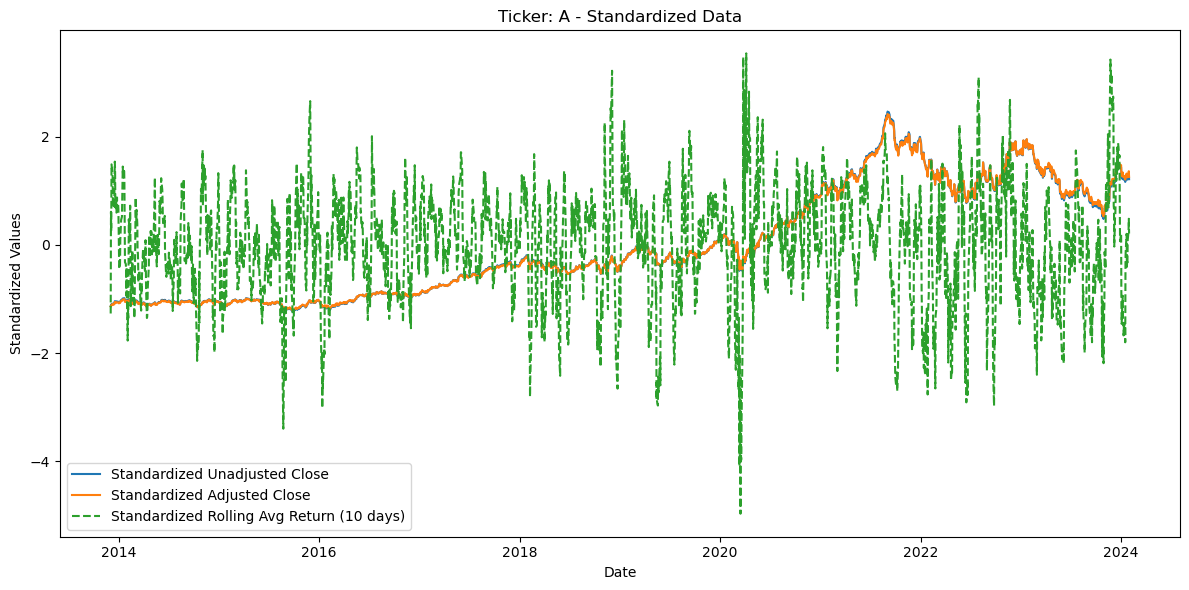

In [87]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

start = time.time()

# Choose a specific ticker
ticker_to_plot = 'A'

# Select data for the chosen ticker
ticker_data = pd_feat.loc[ticker_to_plot]

# Plot the standardized data 
# to ensure consistent scaling and visibility of smaller numerical values
scaler = StandardScaler()
ticker_data[['Close_scaled', 'Adj_Close_scaled', 'rolling_avg_return_scaled', 'Volume_scaled', 'returns_scaled']] = scaler.fit_transform(ticker_data[['Close', 'Adj_Close', 'rolling_avg_return', 'Volume', 'returns']])

# Plotting the data
fig, ax = plt.subplots(figsize=(12, 6))

# Plot scaled unadjusted Close prices
ax.plot(ticker_data['Date'], ticker_data['Close_scaled'], label='Standardized Unadjusted Close')

# Plot scaled adjusted Close prices
ax.plot(ticker_data['Date'], ticker_data['Adj_Close_scaled'], label='Standardized Adjusted Close')

# Plot scaled rolling average return
ax.plot(ticker_data['Date'], ticker_data['rolling_avg_return_scaled'],
        label='Standardized Rolling Avg Return (10 days)', linestyle='--')

# # Plot scaled Volume
# ax.plot(ticker_data['Date'], ticker_data['Volume_scaled'], label='Standardized Volume', linestyle='-.')

# # Plot scaled returns
# ax.plot(ticker_data['Date'], ticker_data['returns_scaled'], label='Standardized Returns', linestyle=':')

# Customize plot
ax.set_xlabel('Date')
ax.set_ylabel('Standardized Values')
ax.set_title(f'Ticker: {ticker_to_plot} - Standardized Data')
ax.legend()

end = time.time()
print(f'The code took {end - start} seconds.')

# Show plot
plt.tight_layout()
plt.show()


## Criteria

|Criteria|Complete|Incomplete|
|---------------------|----|----|
|Calculations         |Calculations were done correctly.|Calculations were not done correctly.|
|Explanation of answer|Answer was concise and explained the learner's reasoning in depth.|Answer was not concise and did not explained the learner's reasoning in depth.|

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_1.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.